In [0]:
%pip install spark-nlp==5.5.2
%pip install nltk

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.3/636.3 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: spark-nlp
    Found existing installation: spark-nlp 5.5.3
    Uninstalling spark-nlp-5.5.3:
      Successfully uninstalled spark-nlp-5.5.3
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 57.4 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from collections import Counter
from pyspark.sql.types import StringType
from pyspark.sql.functions import regexp_replace
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [0]:
def get_random_book_text():
    text = spark.sql("SELECT book_text FROM book_to_process WHERE book_id = 78")
    return text

In [0]:
generated_text = get_random_book_text().collect()[0][0]
split_text = generated_text.split("CHAPTER")
filtered_chapters = [chapter for chapter in split_text if len(chapter) >= 100]
filtered_chapters = filtered_chapters[1:]
pre_text = ', '.join(filtered_chapters)
pre_text = pre_text.split('END OF THE PROJECT GUTENBERG EBOOK')
cleaned_book_text = pre_text[0]   

In [0]:
import string
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
text_without_punctuation = ''.join([char if char not in string.punctuation else ' ' for char in cleaned_book_text])
words = text_without_punctuation.split()
filtered_words = [word for word in words if word.lower() not in stop_words]
filtered_text = ' '.join(filtered_words)
filtered_text = filtered_text.replace('“', ' ').replace("’", ' ').replace('”', ' ')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# import sparknlp
# from sparknlp.annotator import DocumentAssembler, Tokenizer, NGramGenerator
# from pyspark.ml import Pipeline
# from sparknlp.common import *
# from sparknlp.base import *


# print(cleaned_book_text)

# ngram_text = spark.createDataFrame([(cleaned_book_text,)], ['text'])

# ngram = NGramGenerator().setN(3).setInputCols(["token"]).setOutputCol("ngrams")

# document_assembler = DocumentAssembler().setInputCol("text").setOutputCol("document")

# tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("token")

# pipeline = Pipeline(stages=[document_assembler, tokenizer, ngram])

# model = pipeline.fit(ngram_text)
# result = model.transform(ngram_text)

# result.select("ngrams").show()

In [0]:
nltk.download('punkt_tab')
tokens = nltk.word_tokenize(filtered_text)
trigrams = list(ngrams(tokens, 3))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [0]:
trigram_freq = Counter(trigrams)

In [0]:
import pandas as pd
from pyspark.sql.functions import desc, col, udf

def return_str_from_dict(dict):
    return ', '.join(sorted(dict))

udf = udf(return_str_from_dict, StringType())

counter_df = spark.createDataFrame(trigram_freq.items(), ["trigram", "freq"])
counter_df = counter_df.withColumn('trigram', udf(col('trigram')))
counter_df = counter_df.sort(desc('freq'))
counter_df = counter_df.limit(20)
print(counter_df.count())
counter_pd = counter_df.toPandas()


20


In [0]:
counter_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   trigram  20 non-null     object
 1   freq     20 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 448.0+ bytes


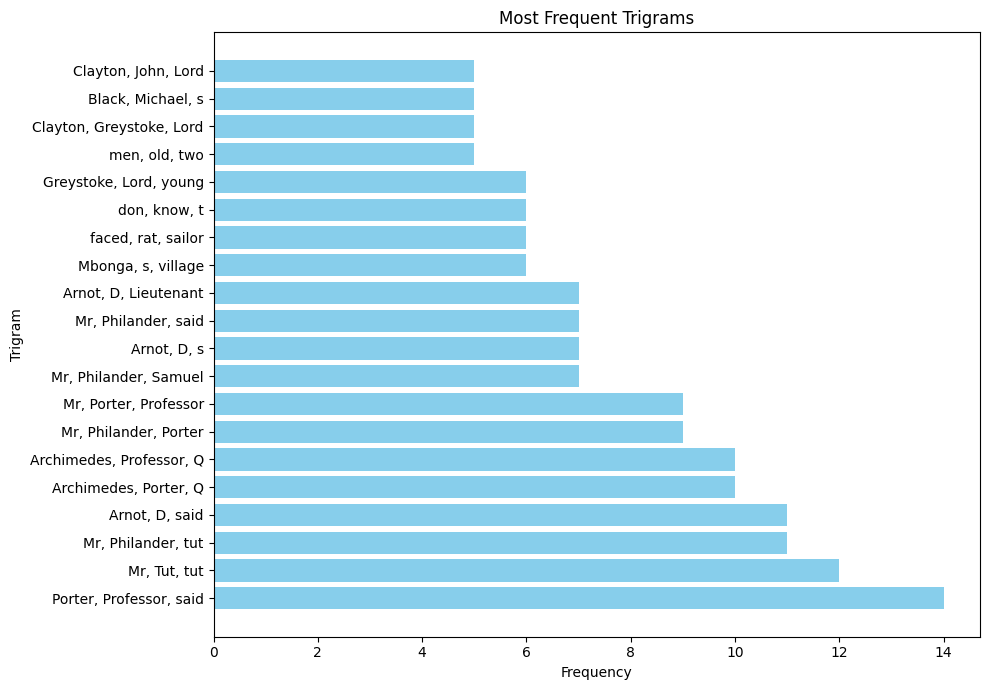

In [0]:
plt.figure(figsize=(10, 7))
plt.barh(counter_pd['trigram'], counter_pd['freq'], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Trigram')
plt.title("Most Frequent Trigrams")
plt.tight_layout()

plt.show()